# Energy System Modelling - Tutorial V.3

Diesel can be produced via Fischer-Tropsch process from hydrogen and carbon dioxide. The necessary CO$_2$ can be captured from the atmosphere with direct air capture (DAC) and than be stored.

Model the production of diesel via Fischer-Tropsch-process in PyPSA.  Build a pypsa model including transport and electricity demand. Add a store for hydrogen, gas and CO$_2$. Electricity can be generated with an Open-Cycle-gas turbine (OCGT) and for transport diesel cars can be used. All the diesel used during the investigated time period should also be produced via Fischer-Tropsch.

In [124]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

__(a) Read the demand (unit MWh) for electricity and transport from the csv file__ 

In [125]:
demand = pd.read_csv("./data/elec_transport_demand.csv", index_col=0, parse_dates=[0])

Plot the demand for electricity and transport.

Text(0, 0.5, 'demand [GWh]')

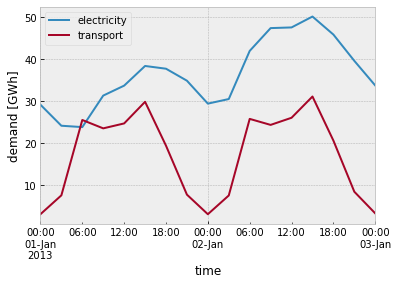

In [126]:
ax = (demand/1e3).plot()
ax.set_xlabel("time")
ax.set_ylabel("demand [GWh]")

__How do you explaing the shape of the transport demand? (write your thoughts here)__

* higher demand during the day
* peak demand at rush hour times in the morning and in the evening (more pronounced in the evening)

__(b) What is the meaning of ```e_cyclic```, ```e_initial``` and ```e_min_pu``` for the component store in the PyPSA syntax? (look in the [pypsa documentation]("https://pypsa.readthedocs.io/en/latest/components.html#store"), write your thoughts here)__

* e_cyclic : the initial energy in the store has to be equal to the final energy in the store
* e_min_pu : gives the minimum allowed energy relative to e_nom. If it is set to -1, the storage can be also negative with maximum negative store capacity of e_nom.
* e_initial: energy in the store at the beginning of the optmisation

__(c) Create a pypsa network to model the production of synthetic fuels. To do so, allow multi-links__

Allow pypsa component link to have multiple out- and inputs (see [pypsa documentation](https://pypsa.org/doc/components.html#link-with-multiple-outputs-or-inputs))

In [127]:
override_component_attrs = pypsa.descriptors.Dict({k : v.copy() for k,v in pypsa.components.component_attrs.items()})
override_component_attrs["Link"].loc["bus2"] = ["string",np.nan,np.nan,"2nd bus","Input (optional)"]
override_component_attrs["Link"].loc["bus3"] = ["string",np.nan,np.nan,"3rd bus","Input (optional)"]
override_component_attrs["Link"].loc["efficiency2"] = ["static or series","per unit",1.,"2nd bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["efficiency3"] = ["static or series","per unit",1.,"3rd bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["p2"] = ["series","MW",0.,"2nd bus output","Output"]
override_component_attrs["Link"].loc["p3"] = ["series","MW",0.,"3rd bus output","Output"]

In [128]:
n = pypsa.Network(override_component_attrs=override_component_attrs)

Set the snapshots as the index of the demand time series


In [129]:
n.set_snapshots(demand.index)

Add a bus and the corresponding load for the carriers transport, electricity

In [130]:
# electric bus + load
n.add("Bus",
      "electric")

n.add("Load",
      "electric",
      bus="electric",
      p_set=demand["electricity"])

# transport bus + load 
n.add("Bus",
      "transport")

n.add("Load",
      "transport",
      bus="transport",
      p_set=demand["transport"])


Add a bus for hydrogen, gas and diesel and a corresponding store


In [131]:
# hydrogen 
n.add("Bus",
      "hydrogen")

n.add("Store",
      "hydrogen",
      bus="hydrogen",
      e_nom=1e6,
      e_initial=1e6,
      marginal_cost=213.)

# gas
n.add("Bus",
      "gas")

n.add("Store",
      "gas",
      bus="gas",
      e_nom=6e6,
      e_initial=6e6,
      marginal_cost=23.)

# diesel
n.add("Bus",
      "diesel")

n.add("Store",
      "diesel",
      bus="diesel",
      e_cyclic=True,
      e_nom_extendable=True)


The CO2 can be stored (for example in [underground caverns](https://en.wikipedia.org/wiki/Carbon_capture_and_storage#Geological_storage)). To model CO2 storage we have to keep track of the CO2
which is emitted to the atmosphere. Therefore we add a bus and a storage for the CO2 in the atmosphere 
and the stored CO2. The storage energy in our model can also become negative, e.g. if more CO2 is removed from the atmosphere than what there was initially.

In [132]:
# minus sign because opposite to how fossil fuels used:
# CH4 burning puts CH4 down, atmosphere up
n.add("Carrier",
      "co2",
      co2_emissions=-1.)

# CO2 in the atmosphere
n.add("Bus",
      "co2 atmosphere",
      carrier="co2")

n.add("Store",
      "co2 atmosphere",
      bus="co2 atmosphere",
      e_min_pu=-1,
      e_nom_extendable=True)

# CO2 stored
n.add("Bus",
      "co2 stored")

n.add("Store",
      "co2 stored",
      bus="co2 stored",
      e_min_pu=-1,
      capital_cost=20,
      e_nom_extendable=True,)

Add the possibility of [Direct Air Capture (DAC)](https://en.wikipedia.org/wiki/Direct_air_capture) of CO2 by adding a PyPSA link. The CO2 is captured from the atmosphere and stored.

In [133]:
# Direct Air Capture (DAC)
n.add("Link",
      "DAC",
      bus0="co2 atmosphere",
      bus1="co2 stored",
      efficiency=1,
      marginal_cost=100,
      p_nom_extendable=True)

__Why do we need to keep track of the CO2 by adding a bus and store for the CO2 in the atmosphere?__

If we want to model Carbon Capture and Storage it is necessary to keep track of the CO2.
We want to know how much CO2 is stored e.g. to used this stored CO2 to produce diesel.

Add diesel cars to satisfy the transport demand using a multi-link

In [134]:
# diesel car
n.add("Link",
      "diesel car",
      bus0="diesel",
      bus1="transport",
      bus2="co2 atmosphere",
      efficiency=0.35,
      efficiency2=1.,
      p_nom_extendable=True)

Add a open-cyclce gas turbine (OCGT) to satisfy the electricity demand

In [135]:
# OCGT
n.add("Link",
      "OCGT",
      bus0="gas",
      bus1="electric",
      bus2="co2 atmosphere",
      efficiency=0.5,
      efficiency2=1,
      capital_cost=2e3,
      marginal_cost=2,
      p_nom_extendable=True)

Diesel can be produced from H2 and CO2 via [Fischer-Tropsch](https://en.wikipedia.org/wiki/Fischer%E2%80%93Tropsch_process).
Add a link which represents this process

In [136]:
n.add("Link",
      "Fischer-Tropsch",
      bus0="hydrogen",
      bus1="diesel",
      bus2="co2 stored",
      efficiency=1.,
      efficiency2=-1,
      capital_cost=145,
      p_nom_extendable=True)

__(d) Run an investment optimisation__

In [137]:
n.lopf()

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 433111995.723929
  Upper bound: 433111995.723929
  Number of objectives: 1
  Number of constraints: 443
  Number of variables: 246
  Number of nonzeros: 915
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.016727924346923828
# ----------------------------------------------------------
#   Solution Information
# --------

('ok', 'optimal')

Now we can set an upper limit for the CO2 emissions and add this limit as an additional constraint to the 
optimisation problem

__(d)(i) Show that the total amount of CO2 in the system stays constant__

In [138]:
n.stores_t.e[["co2 stored","co2 atmosphere","gas","diesel"]].sum(axis=1)

name
2013-01-01 00:00:00    6.064654e+06
2013-01-01 03:00:00    6.064654e+06
2013-01-01 06:00:00    6.064654e+06
2013-01-01 09:00:00    6.064654e+06
2013-01-01 12:00:00    6.064654e+06
2013-01-01 15:00:00    6.064654e+06
2013-01-01 18:00:00    6.064654e+06
2013-01-01 21:00:00    6.064654e+06
2013-01-02 00:00:00    6.064654e+06
2013-01-02 03:00:00    6.064654e+06
2013-01-02 06:00:00    6.064654e+06
2013-01-02 09:00:00    6.064654e+06
2013-01-02 12:00:00    6.064654e+06
2013-01-02 15:00:00    6.064654e+06
2013-01-02 18:00:00    6.064654e+06
2013-01-02 21:00:00    6.064654e+06
2013-01-03 00:00:00    6.064654e+06
dtype: float64

__(d)(ii) Plot the energy difference in the plots. You can use the pandas function ```diff()```__

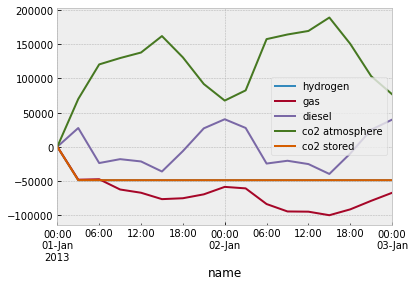

In [139]:
n.stores_t.e.diff().fillna(0).plot()

__(d)(iii) What are the total system costs?__

In [140]:
costs_no_limit = n.objective
n.objective

433111995.723929

__(e) Now add an constraint for the CO2 content in the atmosphere in the last time step to zero and rerun the investment optimisation (see also in PyPSA [documentation]("https://pypsa.readthedocs.io/en/latest/components.html#global-constraints") ```GlobalConstraint```)__

In [141]:
limit = 0
n.add("GlobalConstraint",
      "co2_limit",
      sense="<=",
      carrier_attribute="co2_emissions",
      constant=limit)

n.lopf()

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 648561532.368272
  Upper bound: 648561532.368272
  Number of objectives: 1
  Number of constraints: 444
  Number of variables: 246
  Number of nonzeros: 916
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.016194820404052734
# ----------------------------------------------------------
#   Solution Information
# --------

('ok', 'optimal')

__How large are the total system costs now?__

In [142]:
costs_limit = n.objective
print("total_costs: ",n.objective, "increased by ", costs_limit/costs_no_limit)

total_costs:  648561532.368272 increased by  1.4974453230837623


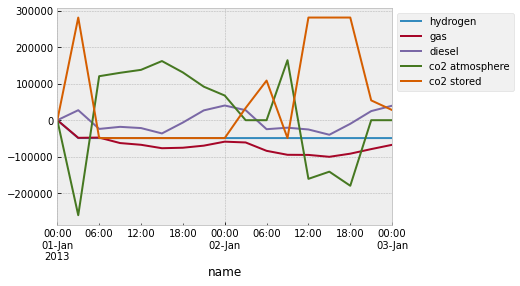

In [143]:
n.stores_t.e.diff().fillna(0).plot().legend(bbox_to_anchor=(1,1))

__How much CO2 storage capacity is necessary?__

In [144]:
n.stores.loc["co2 stored", "e_nom_opt"]

1239770.5846896

__(f) Add electric cars to the problem (using a PyPSA "Link" and the given efficiency) and solve the optimisation problem again. How large is the share of electric cars?__

In [145]:
# electric car
n.add("Link",
      "electric car",
      bus0="electric",
      bus1="transport",
      efficiency=0.9,
      p_nom_extendable=True)

n.lopf()
n.links.p_nom_opt

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 560928132.466879
  Upper bound: 560928132.466879
  Number of objectives: 1
  Number of constraints: 478
  Number of variables: 264
  Number of nonzeros: 1001
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.0189821720123291
# ----------------------------------------------------------
#   Solution Information
# ---------

DAC                487594.246212
diesel car          65484.957637
OCGT               118652.560319
Fischer-Tropsch     14049.945598
electric car        28374.474126
Name: p_nom_opt, dtype: float64

In [146]:
energy_transport = abs(n.links_t.p1[["diesel car", "electric car"]]).sum()
print("share of electric cars: ", energy_transport.loc["electric car"]/energy_transport.sum())

share of electric cars:  0.7134258145739893


__(g) Now add the possibility to generate electricity with an onshore wind turbine. The time serie for the wind turbine is given in the data folder (wind_time_series.csv) and run the optimisation again. How large is the share of electric cars now?__

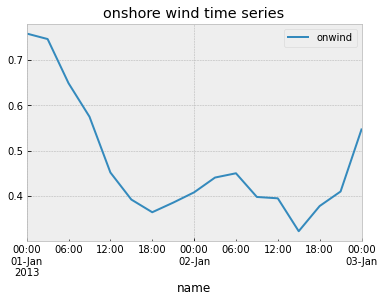

In [147]:
wind_timeseries = pd.read_csv("./data/wind_time_series.csv", index_col=0,
                              parse_dates=[0])

wind_timeseries.plot(title="onshore wind time series")

n.add("Generator",
      "onwind",
      bus="electric",
      capital_cost=1.5e3,
      p_max_pu = wind_timeseries["onwind"],
      p_nom_extendable=True)

In [148]:
n.lopf()
n.links.p_nom_opt

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 300592703.188756
  Upper bound: 300592703.188756
  Number of objectives: 1
  Number of constraints: 512
  Number of variables: 282
  Number of nonzeros: 1069
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.01800084114074707
# ----------------------------------------------------------
#   Solution Information
# --------

DAC                 4984.121485
diesel car         67047.484844
OCGT                   0.000000
Fischer-Tropsch     4984.121485
electric car       33011.794208
Name: p_nom_opt, dtype: float64

In [149]:
abs(n.links_t.p1[["diesel car", "electric car"]]).sum()

diesel car       29655.522835
electric car    262056.643022
dtype: float64

In [150]:
n.loads_t.p_set["transport"].sum()

291712.1658569545

In [151]:
energy_transport = abs(n.links_t.p1[["diesel car", "electric car"]]).sum()
print("share of electric cars: ", energy_transport.loc["electric car"]/energy_transport.sum())

share of electric cars:  0.8983397804196298
